# 04_model_selection — 교차검증(K-Fold)과 모델 선택(GridSearch)

오늘 이 노트북에서 차근차근 할 일

1) 왜 훈련한 데이터로 그대로 평가하면 안 되는지 직접 확인한다.
2) 훈련용과 시험용으로 나누어 평가하는 방법(train/test split)을 배운다.
3) 그래도 결과가 흔들릴 수 있어서, 데이터를 여러 번 나눠 평균을 내는 방법(교차검증, K-Fold)을 배운다.
4) K-Fold를 사람이 일일이 코딩하지 않고, 한 줄로 실행하는 방법(cross_val_score)을 배운다.
5) 모델의 설정값(하이퍼파라미터)을 바꾸면 결과가 달라진다는 걸 확인하고,
   여러 후보를 공정하게 비교해 최적을 찾는 방법(GridSearchCV)을 배운다.
6) 마지막으로, 처음 보는 시험지(test set)에서 한 번 더 성능을 확인한다.

## 훈련 데이터로 평가하면 왜 안 되는가

직접 해보면 알 수 있습니다.
같은 문제로 공부하고, 같은 문제로 시험을 보면 성적이 아주 높게 나옵니다.
하지만 그건 "시험지를 외운 것"이지, 진짜 실력이 아닙니다.

아래 코드는 그런 "착시"를 직접 보여줍니다.

In [4]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

iris = load_iris()
X_full, y_full = iris.data, iris.target

# 모델 선정(생성)
# random_state = 42 -> 동일한 결과를 얻기 위해서
clf = DecisionTreeClassifier(random_state=42)
# 모델 학습(fit)
clf.fit(X_full, y_full)

# 예측
y_pred_full = clf.predict(X_full)

# 정확도 평가
print(f"Accuracy: {accuracy_score(y_full, y_pred_full):.3f}")

Accuracy: 1.000


## 훈련=평가 착시



위 결과는 대부분 1.000(100%)에 가깝게 나옵니다.
왜냐하면, 나누지 않아서!

## 올바른 평가: train/test split

방법은 간단합니다.
데이터를 두 덩어리로 나눕니다.

- 훈련(train) 데이터: 모델이 공부하는 데이터
- 시험(test) 데이터: 모델이 처음 보는 데이터(시험지)

시험 데이터로 성적을 확인하면, "처음 보는 문제"에서의 진짜 실력을 알 수 있습니다.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

# 모델 생성
clf = DecisionTreeClassifier(random_state=42)
# 훈련 데이터셋으로 학습
clf.fit(X_train, y_train)
# 예측(시험 데이터 셋으로 예측)
y_pred_test = clf.predict(X_test)

# 정확도 평가(시험 데이터셋을 기준으로)
print(f"[train/test split 기준선] Accuracy: {accuracy_score(y_test, y_pred_test):.3f}")

[train/test split 기준선] Accuracy: 0.933


## train/test split (현실적인 성능)

데이터를 훈련(train)과 시험(test)으로 나눠야 하는 이유는 단순합니다.
시험 데이터는 모델이 **처음 보는 문제**이기 때문에, 여기서 나온 점수가 **현실적인 성능**입니다.
→ 시험지를 외우는 게 아니라, 진짜 실력을 보는 과정입니다.

## 교차검증(K-Fold) 소개

1) 데이터를 K개로 나눕니다.
2) 그 중 1개는 시험용, 나머지 K-1개는 훈련용으로 써서 성적을 구합니다.
3) 시험용으로 쓰는 조각을 바꿔가며 K번 반복합니다.
4) 마지막에 K번 성적을 평균(±표준편차)으로 정리합니다.

이렇게 하면 "운"의 영향을 줄이고, 더 안정적인 성능을 얻을 수 있습니다.

분류 문제에서는 "클래스 비율"을 유지하는 StratifiedKFold를 사용합니다.

In [6]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# n_splits=5 -> 데이터를 5개 쪼개, shuffle-> 섞는다구, random_state=seed(결과값 같게)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_scores = []
for fold, (train_idx, test_idx) in enumerate(kf.split(X_full, y_full), 1):
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_full[train_idx], y_full[train_idx])
    score = accuracy_score(y_full[test_idx], model.predict(X_full[test_idx]))
    fold_scores.append((fold, score))

df_scores = pd.DataFrame(fold_scores, columns=["Fold", "Accuracy"])
display(df_scores)
print("평균=%.3f, 표준편차=%.3f" % (df_scores['Accuracy'].mean(), df_scores['Accuracy'].std()))

,Fold,Accuracy
0,1,1.000000
1,2,0.966667
2,3,0.933333
3,4,0.966667
4,5,0.900000


평균=0.953, 표준편차=0.038


방금은 교차검증의 "원리"를 직접 코드로 실행해 본 거임..
한 번만 나눠서 나온 성적이 아니라, 여러 번 나눠 평균내었기 때문에 더 믿을 만함

하지만 이렇게 매번 for문을 돌리는 것은 귀찮....


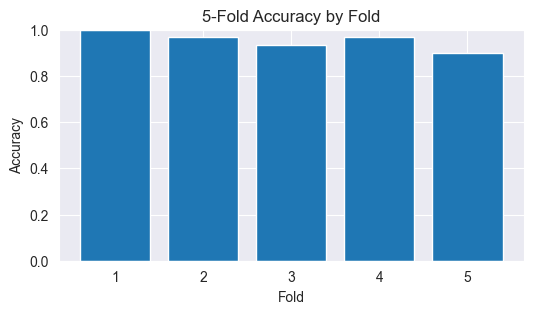

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
plt.bar(df_scores["Fold"], df_scores["Accuracy"])
plt.ylim(0,1)
plt.title("5-Fold Accuracy by Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.show()

## cross_val_score로 간단히 교차검증

위 과정을 scikit-learn이 자동으로 해줍니다.
평균 성적과 표준편차를 바로 얻을 수 있습니다.


In [8]:
from sklearn.model_selection import cross_val_score

# cross_val_score라는 클래스로 cv_scores 객체 선언
cv_scores = cross_val_score(
    # 모델 생성
    DecisionTreeClassifier(random_state=42),
    # 전체 데이터와 전체 답(레이블), cv=5(교차검증 몇 번 쪼개는거 몇번, 점수 내는 방법)
    X_full, y_full, cv=5, scoring="accuracy"
)

# 객체의 메서드 호출(mean, std)
print(f"[cross_val_score] mean={cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

[cross_val_score] mean=0.953 ± 0.034


## cross_val_score

앞에서 for문으로 Fold를 돌려 평균 점수를 계산했죠?
`cross_val_score`는 같은 일을 **한 줄로 자동**으로 해줍니다.
마치 성적표를 손으로 일일이 합산하지 않고, 계산기가 자동으로 평균을 내주는 것과 같습니다.

## 하이퍼파라미터가 성능에 미치는 영향: max_depth

결정트리의 `max_depth` 값은 트리의 깊이를 정함

- 너무 작으면: 모델이 너무 단순해서 중요한 패턴을 놓칠 수 있습니다(언더피팅).
- 너무 크면: 훈련 데이터에만 지나치게 맞추고(외워버리고), 새로운 데이터에 약할 수 있습니다(오버피팅).

교차검증으로 후보 값들을 공정하게 비교해보자.

## 언더피팅 vs 오버피팅

- 언더피팅: 트리 깊이가 너무 얕음
- 오버피팅: 트리 깊이가 너무 깊음
- 적당한 깊이가 필요합니다 → 균형 잡힌 공부 습관

In [10]:
import pandas as pd

# depth 임의 리스트 정의(None = 트리가 끝까지 자라나라 머리머리)
depth_candidates = [2, 3, 4, None]
# 결과값 저장
rows = []

for d in depth_candidates:
    scores = cross_val_score(
        # max_depth = 2, 3, 4, None 해서 row에 결과값 저장
        DecisionTreeClassifier(max_depth=d, random_state=42),
        X_full, y_full, cv=5, scoring="accuracy"
    )
    rows.append((d, scores.mean(), scores.std()))

df_depth = pd.DataFrame(rows, columns=["max_depth", "cv_mean_acc", "cv_std"]) \
    .sort_values("cv_mean_acc", ascending=False) \
    .reset_index(drop=True)
display(df_depth)

,max_depth,cv_mean_acc,cv_std
0,3.0,0.973333,0.024944
1,4.0,0.953333,0.033993
2,NaN,0.953333,0.033993
3,2.0,0.933333,0.047140


위 표를 보면, 어떤 깊이에서 평균 성적이 가장 좋은지 알 수 있습니다.
이제 후보를 더 넓혀서 자동으로 찾아주는 방법을 사용해 보겠습니다.

깊이 vs 성능 간단 선그래프**
최적 깊이 근처에서 성능이 가장 높은 모습을 그림으로 보여줍니다.

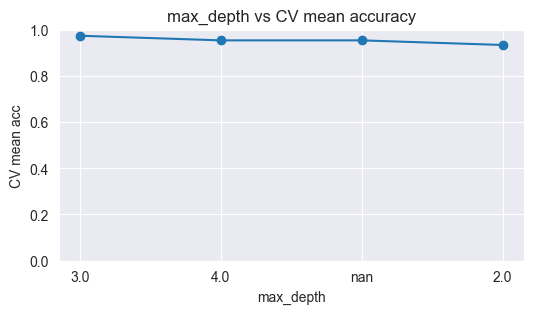

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
x = [str(d) for d in df_depth["max_depth"]]
plt.plot(x, df_depth["cv_mean_acc"], marker="o")
plt.ylim(0, 1)
plt.title("max_depth vs CV mean accuracy")
plt.xlabel("max_depth")
plt.ylabel("CV mean acc")
plt.show()

## GridSearchCV: 여러 후보를 자동으로 탐색

- 여러 파라미터 후보(예: max_depth, min_samples_split)를 지정합니다.
- GridSearchCV는 내부적으로 교차검증을 사용하여 각 조합의 평균 성적을 계산합니다.
- 가장 좋은 조합(best_params_)과 그때의 성적(best_score_)을 알려주고,
  refit=True이면 그 조합으로 모델을 다시 학습시킵니다.

In [12]:
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터에서 후보 값을 정의
param_grid = {
    "max_depth": [2, 3, 4, None],
    "min_samples_split": [2, 4, 8]
}

# GridSearchCV 클래스를 gs로 객체 선언
gs = GridSearchCV(
    # 모델 선언
    estimator=DecisionTreeClassifier(random_state=42),
    # 후보 파라미터
    param_grid=param_grid,
    # 이거 생략
    cv=5, scoring="accuracy",
    # CPU 코어 얼마나 사용할껀지
    n_jobs=-1,
    # 최적의 파라미러 찾을 시 재학습
    refit=True
)

gs.fit(X_full, y_full)

print(f"best_params_: {gs.best_params_}")
print(f"best_score_ : {gs.best_score_:.3f}")

best_params_: {'max_depth': 3, 'min_samples_split': 2}
best_score_ : 0.973


In [13]:
cvres = pd.DataFrame(gs.cv_results_)
cols = ["mean_test_score", "std_test_score", "param_max_depth", "param_min_samples_split"]
cvres[cols].sort_values("mean_test_score", ascending=False).head(10)

,mean_test_score,std_test_score,param_max_depth,param_min_samples_split
3,0.973333,0.024944,3,2
4,0.973333,0.024944,3,4
5,0.973333,0.024944,3,8
8,0.966667,0.021082,4,8
11,0.966667,0.021082,None,8
6,0.953333,0.033993,4,2
7,0.953333,0.033993,4,4
9,0.953333,0.033993,None,2
10,0.953333,0.033993,None,4
0,0.933333,0.047140,2,2


이 표는 “어떤 설정값 조합이 좋았는지”를 보여줌
GridSearchCV가 교차검증으로 공정하게 비교한 결과

## 최종 홀드아웃 평가

교차검증으로 좋은 조합을 찾았어도, 마지막에는 처음 보는 시험지(test set)에서 성능을 한 번 더 확인해야 함
이 단계가 있어야 "실제로 배포했을 때도 잘 동작할 가능성이 높다"고 말할 수 있음

모의고사(K-Fold)에서 우수 모델을 뽑았으니, 이제 **남겨둔 진짜 시험지(test set)**로 성적을 확인하자


In [20]:
from sklearn.model_selection import train_test_split

best_model = gs.best_estimator_

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

best_model.fit(X_train, y_train)
final_acc = accuracy_score(y_test, best_model.predict(X_test))
print(f"[최종 홀드아웃] Accuracy: {final_acc:.3f}")

[최종 홀드아웃] Accuracy: 0.967


## 요약

1) 훈련 데이터로 평가하면 착시(거의 100%)가 생긴다 → 반드시 train/test split 필요
2) 한 번만 나누면 결과가 흔들릴 수 있다 → K-Fold 교차검증으로 평균±표준편차
3) K-Fold를 자동으로 해주는 함수가 cross_val_score
4) 설정값(하이퍼파라미터)을 바꾸면 성능이 달라진다 → GridSearchCV로 공정 비교
5) 마지막에는 test set에서 한 번 더 확인


## 실습 미션

1) GridSearchCV 파라미터에 `min_samples_leaf=[1,2,4]`를 추가하세요.
   - 다시 실행한 후 상위 5개 결과를 표로 정리하세요.

2) KNN을 사용해 `n_neighbors=[3,5,7,9]`로 5-Fold CV를 수행하세요.
   - Accuracy 평균과 표준편차를 DataFrame으로 정리하세요.
   - 어떤 k가 가장 좋은지, 이유를 한 줄로 설명하세요.

3) 각 모델의 최적 조합으로 다시 test set에서 평가하세요.
   - 성능이 만족스러운지, “실제로 배포했을 때 괜찮을까?”에 대해 본인 생각을 한 줄로 작성하세요.